In [1]:
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import duckdb
import json

# Basic Setup
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
sns.set_palette("Set2")

In [2]:
# Loading the dataset from file using dbduck library
file_path = 'client_part_collection_sample.parquet'
# Read parquet file using DuckDB (easier and efficient for large files)
df = duckdb.query(f"SELECT * FROM '{file_path}'").to_df()

In [3]:
# Dimensions of the dataframe
print(f"Main DataFrame loaded with shape: {df.shape}")

Main DataFrame loaded with shape: (276963, 9)


In [4]:
display(df.head())

,client_id,country,region_id,currency,data_quality,date_added,part_id,unit,sonar_results
0,668e3fb5d2b001a3ad500b8f,DEU,64802c55292b179f4df8e204,EUR,medium,2024-03-21T00:00:00.000Z,65fc34fe23f1a95acc644f69,ST,"[{'amount': 1, 'currency': None, 'date_sonar':..."
1,65577268e32ff87ee1056f82,DEU,64802c55292b179f4df8e204,EUR,medium,2024-03-21T00:00:00.000Z,65fc350123f1a95acc644fe2,ST,"[{'amount': 1, 'currency': None, 'date_sonar':..."
2,65577268e32ff87ee1056f82,DEU,64802c55292b179f4df8e204,EUR,high,2024-05-23T00:00:00.000Z,664f109c58aa1e07d4930646,ST,<NA>
3,65577268e32ff87ee1056f82,DEU,64802c55292b179f4df8e204,EUR,medium,2024-05-23T00:00:00.000Z,664f109c58aa1e07d493064e,ST,<NA>
4,668e3fb5d2b001a3ad500b8f,DEU,64802c55292b179f4df8e204,EUR,high,2024-05-23T00:00:00.000Z,664f109c58aa1e07d4930652,ST,<NA>


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276963 entries, 0 to 276962
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   client_id          276963 non-null  object
 1   country            275510 non-null  object
 2   region_id          276963 non-null  object
 3   currency           276963 non-null  object
 4   data_quality       276963 non-null  object
 5   date_added         213721 non-null  object
 6   part_id            276351 non-null  object
 7   unit               276664 non-null  object
 8   sonar_results      276963 non-null  object
 9   sonar_data_parsed  276963 non-null  object
 10  sonar_parsed       276963 non-null  object
 11  unit_standardized  276963 non-null  object
dtypes: object(12)
memory usage: 25.4+ MB


In [34]:
df.info

<bound method DataFrame.info of                        client_id country                 region_id currency  \
0       668e3fb5d2b001a3ad500b8f     DEU  64802c55292b179f4df8e204      EUR   
1       65577268e32ff87ee1056f82     DEU  64802c55292b179f4df8e204      EUR   
2       65577268e32ff87ee1056f82     DEU  64802c55292b179f4df8e204      EUR   
3       65577268e32ff87ee1056f82     DEU  64802c55292b179f4df8e204      EUR   
4       668e3fb5d2b001a3ad500b8f     DEU  64802c55292b179f4df8e204      EUR   
...                          ...     ...                       ...      ...   
276958  63db8c2f638e84256fb360a6     DEU  6193c5df531ac53cc2bb007a      EUR   
276959  63db8c2f638e84256fb360a6     DEU  6193c5df531ac53cc2bb007a      EUR   
276960  63db8c2f638e84256fb360a6     DEU  6193c5df531ac53cc2bb007a      EUR   
276961  63db8c2f638e84256fb360a6     DEU  6193c5df531ac53cc2bb007a      EUR   
276962  63db8c2f638e84256fb360a6     DEU  6193c5df531ac53cc2bb007a      EUR   

       data_quality

In [14]:
sonar_rows = []

# Try a different approach to iterate through the DataFrame
for index, row in df.iterrows():
    try:
        part_id = str(row['part_id'])
        
        # Safer way to extract and check sonar_results
        raw_sonar = row.get('sonar_results', None)
        
        # Skip if it's clearly NA or empty
        if raw_sonar is None:
            continue
        
        # Check if it's a pandas NA value
        try:
            if pd.isna(raw_sonar):
                continue
        except ValueError:
            # If we get a ValueError, it's likely an array
            # Try to convert it to a list and check if it's empty
            try:
                if isinstance(raw_sonar, str):
                    if raw_sonar.strip() in ('[]', ''):
                        continue
                    
                    # Try to parse JSON
                    try:
                        parsed_data = json.loads(raw_sonar)
                    except:
                        try:
                            # Try literal_eval as fallback
                            import ast
                            parsed_data = ast.literal_eval(raw_sonar)
                        except:
                            # One more attempt with quote replacement
                            fixed_str = raw_sonar.replace("'", '"')
                            try:
                                parsed_data = json.loads(fixed_str)
                            except:
                                print(f"Could not parse sonar data for row {index}, part_id {part_id}")
                                continue
                elif isinstance(raw_sonar, list):
                    parsed_data = raw_sonar
                    if not parsed_data:  # Skip empty lists
                        continue
                else:
                    # Try to iterate and convert to list
                    try:
                        parsed_data = list(raw_sonar)
                        if not parsed_data:
                            continue
                    except:
                        print(f"Skipping row {index}, part_id {part_id} - Could not process sonar data")
                        continue
            except:
                print(f"Skipping row {index}, part_id {part_id} - Error processing sonar data")
                continue
        
        # Process each entry
        if not isinstance(parsed_data, list):
            print(f"Skipping row {index} - parsed_data is not a list, got {type(parsed_data)}")
            continue
            
        for entry in parsed_data:
            if isinstance(entry, dict):
                # Process dictionary fields with stronger validation
                try:
                    # Handle delivery field with range checking
                    delivery = entry.get('delivery')
                    if delivery is not None:
                        try:
                            delivery = int(delivery)
                            # Check for reasonable range
                            if abs(delivery) > 9223372036854775807:  # Max value for BIGINT
                                print(f"Warning: delivery value {delivery} exceeds BIGINT range, setting to NULL")
                                delivery = None
                        except (ValueError, TypeError):
                            delivery = None
                    
                    # Handle price field with range checking
                    price = entry.get('price')
                    if price is not None:
                        try:
                            price = float(price)
                            # Check for reasonable range
                            if not (1e-10 <= abs(price) <= 1e28 or price == 0):
                                print(f"Warning: price value {price} is extreme, setting to NULL")
                                price = None
                        except (ValueError, TypeError):
                            price = None
                    
                    sonar_rows.append({
                        'result_id': entry.get('result_id'),
                        'part_id': part_id,
                        'amount': entry.get('amount'),
                        'currency': entry.get('currency'),
                        'date_sonar': entry.get('date_sonar'),
                        'delivery': delivery,
                        'price': price,
                        'status': entry.get('status'),
                        'supplier_country': entry.get('supplier_country'),
                        'supplier_id': entry.get('supplier_id'),
                        'supplier_name': entry.get('supplier_name')
                    })
                except Exception as e:
                    print(f"Error processing entry in row {index}: {str(e)}")
    except Exception as e:
        print(f"Error processing row {index}: {str(e)}")

# Create DataFrame from parsed data
if not sonar_rows:
    print("No valid sonar data found in the dataset")
    cur.close()
    conn.close()
    exit()

sonar_df = pd.DataFrame(sonar_rows)

In [15]:
sonar_df.head()

,result_id,part_id,amount,currency,date_sonar,delivery,price,status,supplier_country,supplier_id,supplier_name
0,67a8bb5fb7a40ebea39cfa95,65fc34fe23f1a95acc644f69,1,None,2025-01-01T00:00:00.000Z,-99,999.336348,verified,DEU,5fedaa586a415fed17d9e2e2,Radwell
1,67331a9140d60f45a3a64d8b,65fc34fe23f1a95acc644f69,1,None,2024-11-01T00:00:00.000Z,-99,999.336348,verified,DEU,5fedaa586a415fed17d9e2e2,Radwell
2,669bd3e90e27e723c909c67c,65fc34fe23f1a95acc644f69,1,None,2024-07-01T00:00:00.000Z,-99,887.441545,unverified,DEU,5fedaa586a415fed17d9e2e2,Radwell
3,67a8bb5fb7a40ebea39cfa96,65fc34fe23f1a95acc644f69,1,None,2025-01-01T00:00:00.000Z,-99,999.336348,verified,GBR,63341953456d423629020ae1,Radwell UK
4,673311d3774b48332c17c9d9,65fc34fe23f1a95acc644f69,1,None,2024-11-01T00:00:00.000Z,-99,999.336348,verified,GBR,63341953456d423629020ae1,Radwell UK


In [29]:
sonar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4743550 entries, 0 to 4743549
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   result_id         object 
 1   part_id           object 
 2   amount            int64  
 3   currency          object 
 4   date_sonar        object 
 5   delivery          int64  
 6   price             float64
 7   status            object 
 8   supplier_country  object 
 9   supplier_id       object 
 10  supplier_name     object 
dtypes: float64(1), int64(2), object(8)
memory usage: 398.1+ MB


In [28]:
sonar_df.info

<bound method DataFrame.info of                         result_id                   part_id  amount currency  \
0        67a8bb5fb7a40ebea39cfa95  65fc34fe23f1a95acc644f69       1     None   
1        67331a9140d60f45a3a64d8b  65fc34fe23f1a95acc644f69       1     None   
2        669bd3e90e27e723c909c67c  65fc34fe23f1a95acc644f69       1     None   
3        67a8bb5fb7a40ebea39cfa96  65fc34fe23f1a95acc644f69       1     None   
4        673311d3774b48332c17c9d9  65fc34fe23f1a95acc644f69       1     None   
...                           ...                       ...     ...      ...   
4743545  66428162d64243f888ad8585  64ff03cfab3cf1a59770faa6      10     None   
4743546  65bf5ac0fceab8f30e38621e  64ff03cfab3cf1a59770faa6      10     None   
4743547  65605a37e743d4ca59dbeb3d  64ff03cfab3cf1a59770faa6      10     None   
4743548  65018db6dfdc90c113b4d19c  64ff03cfab3cf1a59770faa6       1     None   
4743549  64be90808f09f6deea2bad97  64ff03cfab3cf1a59770faa6       1     None   

       

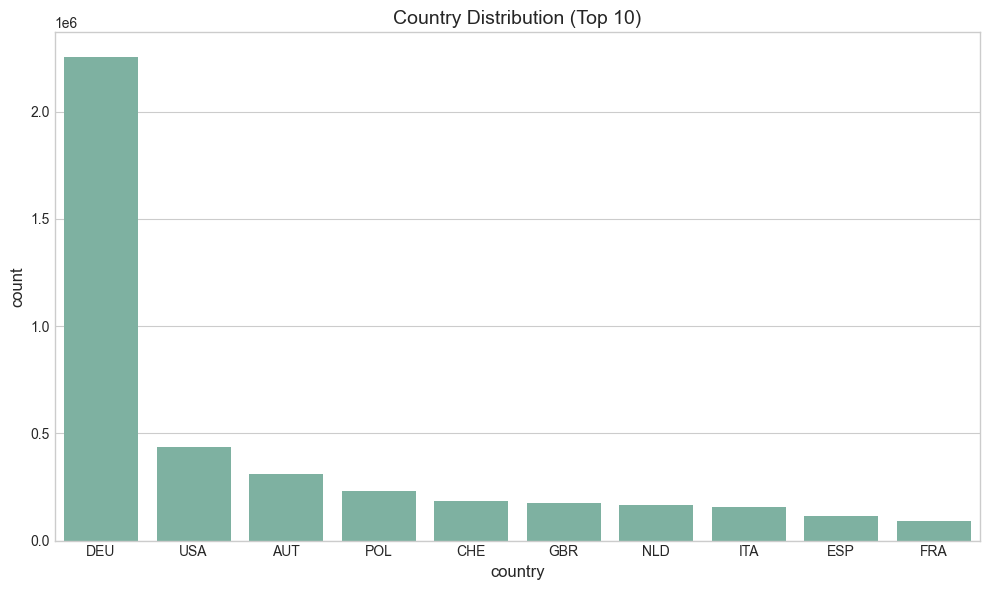

In [38]:
# Set the style for all plots
plt.style.use('seaborn-v0_8-whitegrid')

# ----- Cell 1: Country Distribution (Top 10) -----
plt.figure(figsize=(10, 6))
top_countries = sonar_df['supplier_country'].value_counts().head(10)
sns.barplot(x=top_countries.index, y=top_countries.values, color='#75b9a4')
plt.title('Country Distribution (Top 10)', fontsize=14)
plt.xlabel('country')
plt.ylabel('count')
plt.tight_layout()
plt.show()


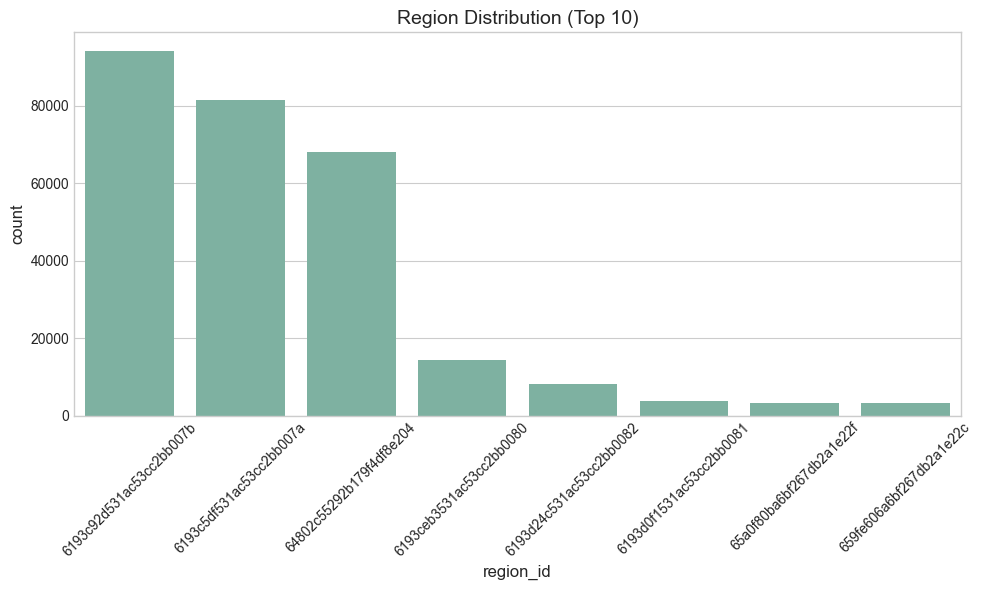

In [17]:
# ----- Cell 2: Region Distribution (Top 10) -----
plt.figure(figsize=(10, 6))
top_regions = df['region_id'].value_counts().head(10)
sns.barplot(x=top_regions.index, y=top_regions.values, color='#75b9a4')
plt.title('Region Distribution (Top 10)', fontsize=14)
plt.xlabel('region_id')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

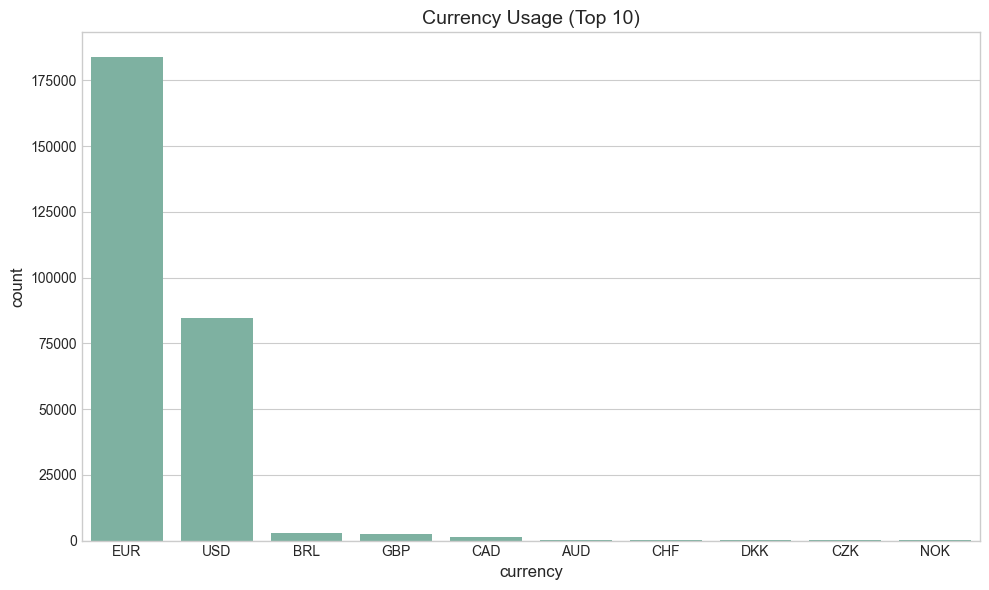

In [18]:
# ----- Cell 3: Currency Usage (Top 10) -----
plt.figure(figsize=(10, 6))
top_currencies = df['currency'].value_counts().head(10)
sns.barplot(x=top_currencies.index, y=top_currencies.values, color='#75b9a4')
plt.title('Currency Usage (Top 10)', fontsize=14)
plt.xlabel('currency')
plt.ylabel('count')
plt.tight_layout()
plt.show()

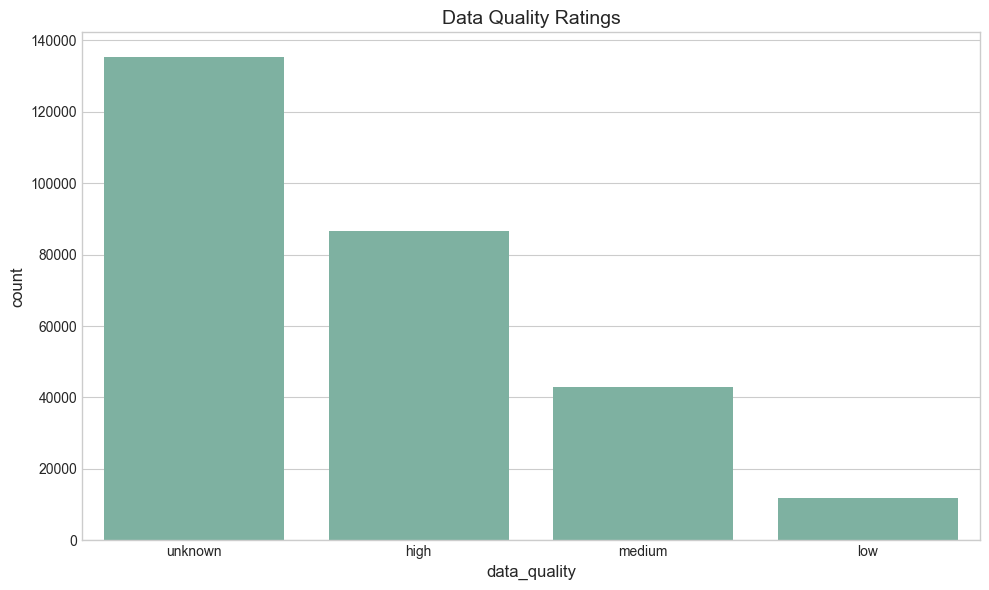

In [19]:
# ----- Cell 4: Data Quality Ratings -----
plt.figure(figsize=(10, 6))
quality_counts = df['data_quality'].value_counts().reindex(['unknown', 'high', 'medium', 'low'])
sns.barplot(x=quality_counts.index, y=quality_counts.values, color='#75b9a4')
plt.title('Data Quality Ratings', fontsize=14)
plt.xlabel('data_quality')
plt.ylabel('count')
plt.tight_layout()
plt.show()

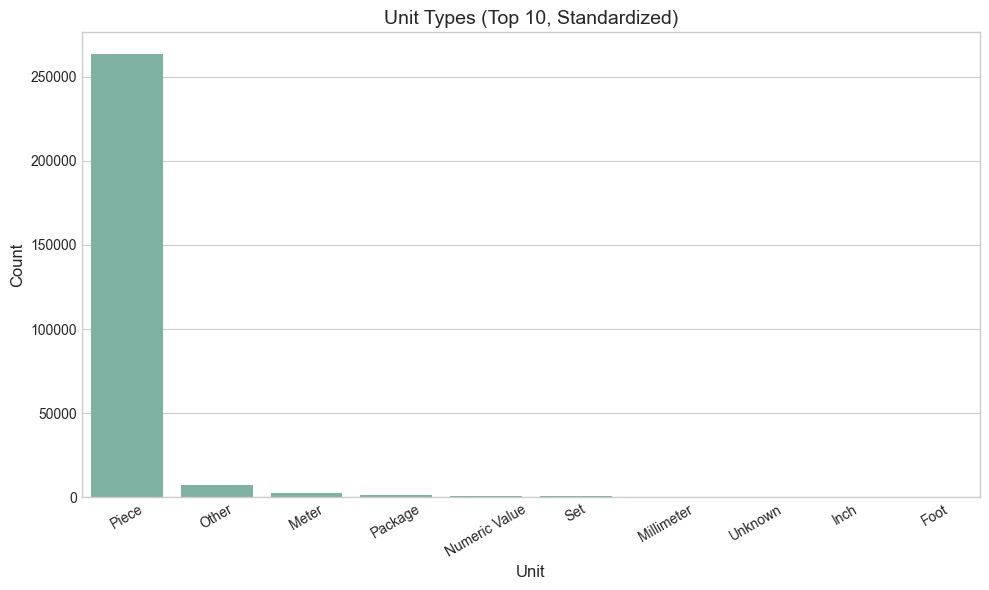

Unit standardization results:


,Original Units,Standardized To
0,ST,Piece
1,EA,Piece
2,ea,Piece
3,Stück,Piece
4,PC,Piece
5,pc,Piece
6,Pcs,Piece
7,pcs,Piece
8,Stk.,Other
9,Stk,Piece


In [26]:
# ----- Cell 5: Unit Types (Top 10) with Standardization -----
plt.figure(figsize=(10, 6))

# Create a mapping function to standardize units as it has non-standard data of units
def standardize_unit(unit):
    if not isinstance(unit, str):
        return "Unknown"
    
    # Convert to lowercase for comparison
    unit_lower = unit.lower().strip()
    
    # Number patterns (likely prices or measurements mistakenly in unit column)
    if unit_lower.replace('.', '').isdigit() or unit_lower.startswith(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')):
        return "Numeric Value"
    
    # Standardize common units
    if unit_lower in ('pcs', 'pc', 'pce', 'pcs', 'piece', 'pieces', 'pz', 'pezzi', 'st', 'stück', 'stk', 'stck', 'ea', 'each', 'one unit'):
        return "Piece"
    elif unit_lower in ('kg', 'kgs'):
        return "Kilogram"
    elif unit_lower in ('m', 'meter', 'metres', 'metri', 'mtr', 'meters'):
        return "Meter"
    elif unit_lower in ('ft', 'feet'):
        return "Foot"
    elif unit_lower in ('l', 'liter', 'liters', 'litre', 'litres'):
        return "Liter"
    elif unit_lower in ('mm'):
        return "Millimeter"
    elif unit_lower in ('cm'):
        return "Centimeter"
    elif unit_lower in ('m²', 'm2', 'mq', 'qm'):
        return "Square Meter"
    elif unit_lower in ('par', 'paar', 'paa', 'coppia'):
        return "Pair"
    elif unit_lower in ('set', 'satz', 'sat', 'sz', 'stz', 'stz'):
        return "Set"
    elif unit_lower in ('bag', 'sack'):
        return "Bag"
    elif unit_lower in ('box', 'kar'):
        return "Box"
    elif unit_lower in ('roll', 'rolle', 'rollen', 'rol'):
        return "Roll"
    elif unit_lower in ('bottle', 'fl'):
        return "Bottle"
    elif unit_lower in ('drum', 'dr'):
        return "Drum"
    elif unit_lower in ('pak', 'pkg', 'package', 'packung', 'verpackung'):
        return "Package"
    elif unit_lower in ('gal', 'gl', 'gan'):
        return "Gallon"
    elif unit_lower in ('lb', 'lbs'):
        return "Pound"
    elif unit_lower in ('in', 'inch'):
        return "Inch"
    elif unit_lower in ('g', 'gr', 'gram'):
        return "Gram"
    elif unit_lower in ('yd'):
        return "Yard"
    elif unit_lower in ('mt'):
        return "Metric Ton"
    elif unit_lower in ('si'):
        return "SI"
    elif unit_lower in ('none', 'unknown', '0', 'x'):
        return "Unknown"
    else:
        return "Other"

# Apply standardization
df['unit_standardized'] = df['unit'].apply(standardize_unit)

# Plot standardized units
top_units = df['unit_standardized'].value_counts().head(10)
sns.barplot(x=top_units.index, y=top_units.values, color='#75b9a4')
plt.title('Unit Types (Top 10, Standardized)', fontsize=14)
plt.xlabel('Unit')
plt.ylabel('Count')
plt.xticks(rotation=30)  # Rotated for better readability
plt.tight_layout()
plt.show()

# Optional: See the mapping results
print("Unit standardization results:")
before_after = pd.DataFrame({
    'Original Units': df['unit'].value_counts().index[:20],  # Show top 20 for brevity
    'Standardized To': [standardize_unit(u) for u in df['unit'].value_counts().index[:20]]
})
display(before_after)

0


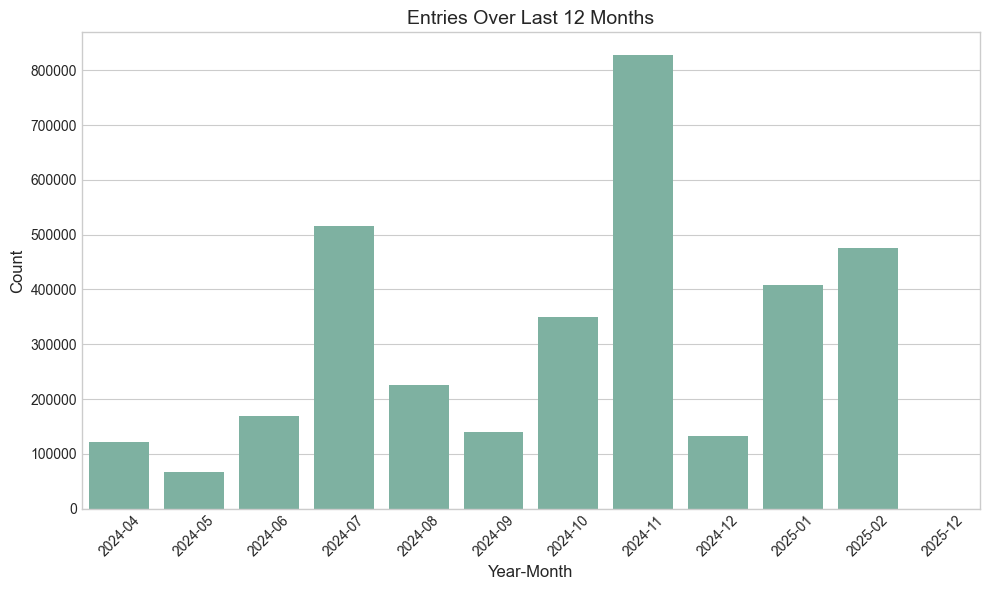

In [32]:
# Ensure the 'date_sonar' column is converted to datetime
sonar_df['date_sonar'] = pd.to_datetime(sonar_df['date_sonar'], errors='coerce')

# Check for any NaT values after conversion (these are invalid date entries)
print(sonar_df['date_sonar'].isna().sum())  # This will tell you how many entries couldn't be parsed

# Group by year-month
sonar_df['Year-Month'] = sonar_df['date_sonar'].dt.strftime('%Y-%m')
monthly_counts = sonar_df.groupby('Year-Month').size().sort_index().tail(12)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, color='#75b9a4')
plt.title('Entries Over Last 12 Months', fontsize=14)
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

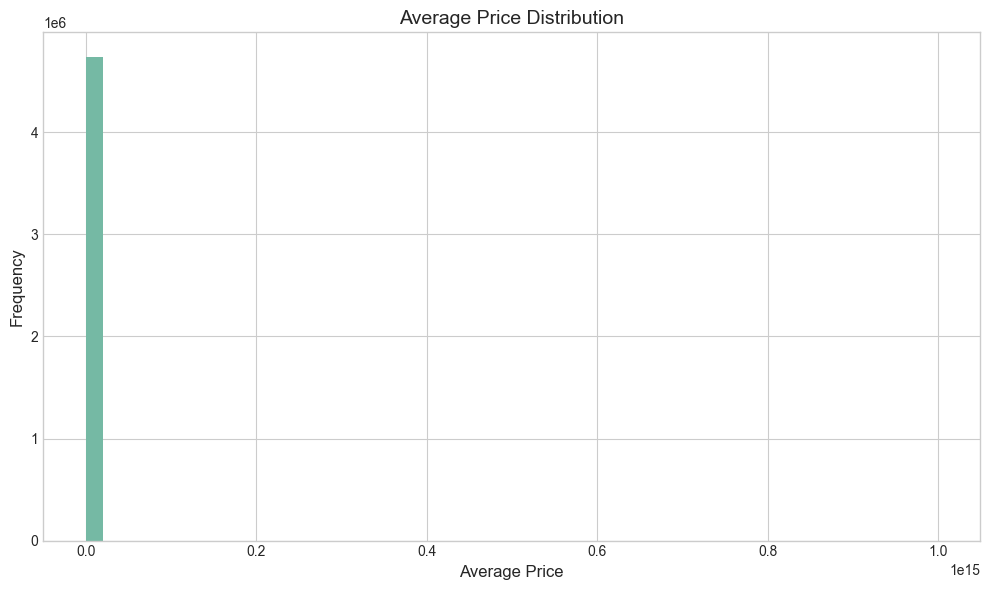

In [35]:
# ----- Cell 7: Average Price Distribution -----
plt.figure(figsize=(10, 6))
plt.hist(sonar_df['price'], bins=50, color='#75b9a4')
plt.title('Average Price Distribution', fontsize=14)
plt.xlabel('Average Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

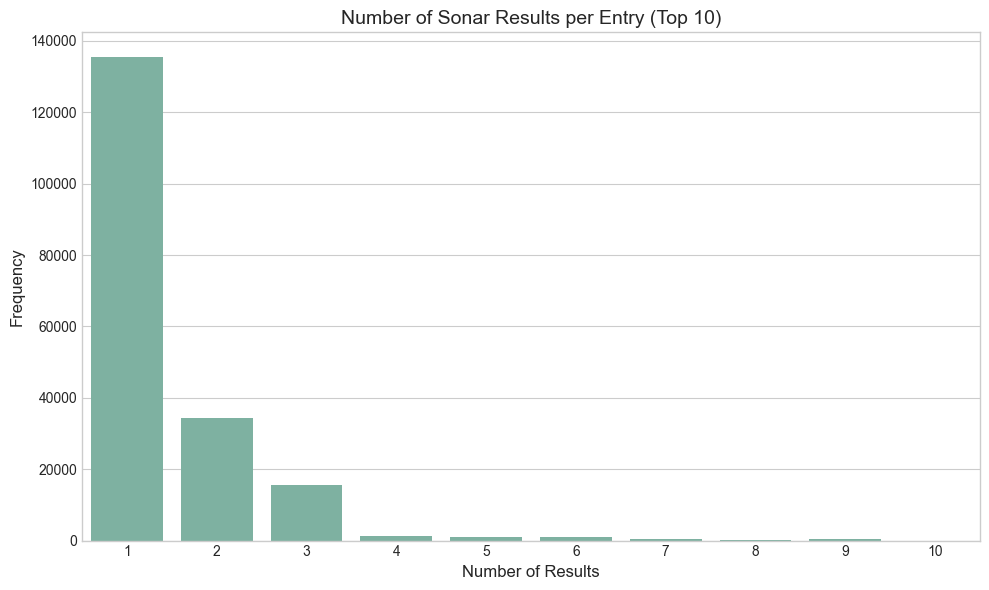

In [23]:
# ----- Cell 8: Number of Sonar Results per Entry -----
plt.figure(figsize=(10, 6))
# Group by part_id and count results
results_per_entry = df.groupby('part_id').size().value_counts().head(10)
sns.barplot(x=results_per_entry.index, y=results_per_entry.values, color='#75b9a4')
plt.title('Number of Sonar Results per Entry (Top 10)', fontsize=14)
plt.xlabel('Number of Results')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

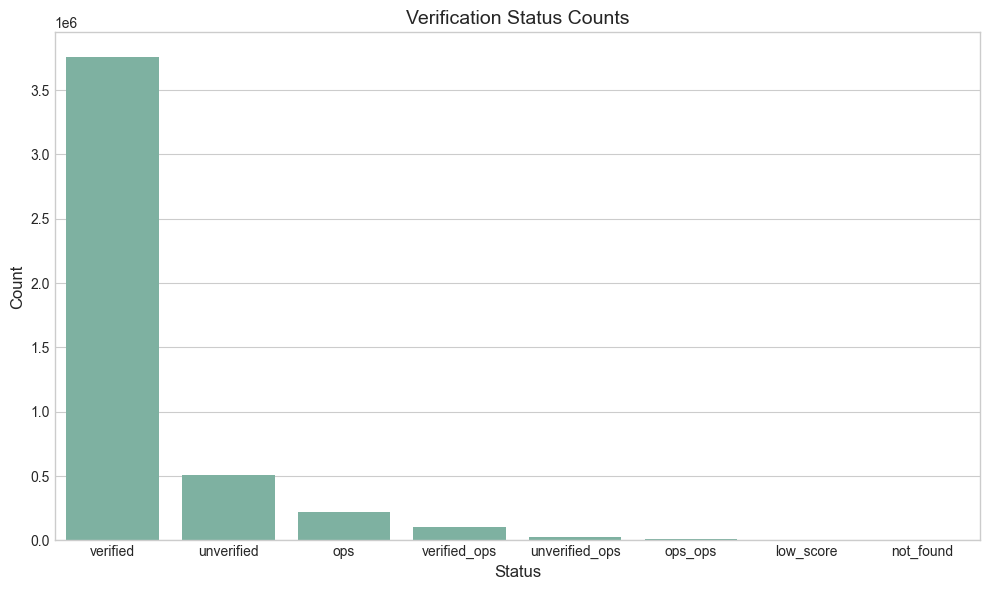

In [36]:
# ----- Cell 9: Verification Status Counts -----
plt.figure(figsize=(10, 6))
status_counts = sonar_df['status'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values, color='#75b9a4')
plt.title('Verification Status Counts', fontsize=14)
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

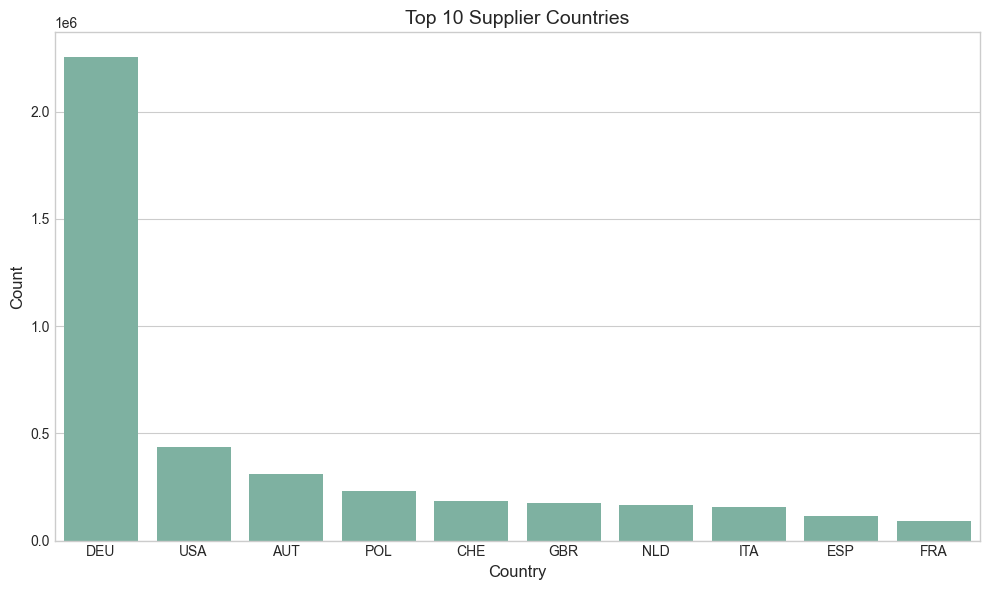

In [37]:
# ----- Cell 10: Top 10 Supplier Countries -----
plt.figure(figsize=(10, 6))
top_suppliers = sonar_df['supplier_country'].value_counts().head(10)
sns.barplot(x=top_suppliers.index, y=top_suppliers.values, color='#75b9a4')
plt.title('Top 10 Supplier Countries', fontsize=14)
plt.xlabel('Country')
plt.ylabel('Count')
plt.tight_layout()
plt.show()